In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [13]:
def extract_first_number(strings):
    results = []
    for s in strings:
        match = re.search(r'\d+(\.\d+)?', str(s))  # Match integers or floats
        results.append(float(match.group()) if match else None)
    return results

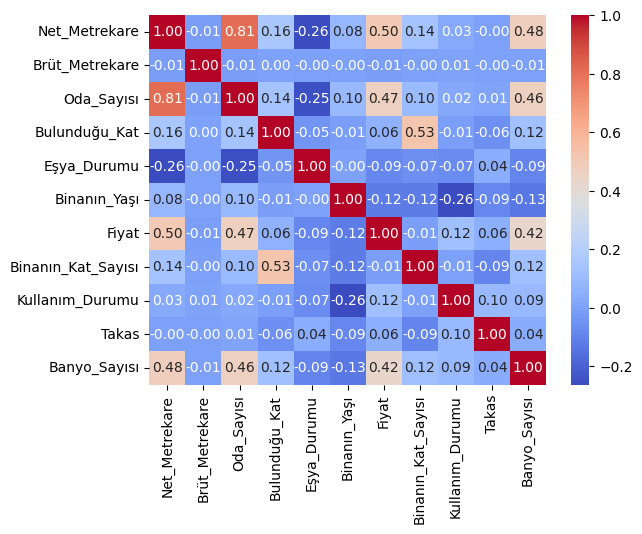

In [ ]:
sample_no = 15000
# Load the dataset
file_path = "data.csv"
df = pd.read_csv(file_path).sample(n=sample_no,random_state=42)
df = df.drop(columns=['Yatırıma_Uygunluk','Şehir','Isıtma_Tipi','Tapu_Durumu'])

# Fill missing values
df['Bulunduğu_Kat'] = extract_first_number(df['Bulunduğu_Kat'])
df['Binanın_Yaşı'] = extract_first_number(df['Binanın_Yaşı'])
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
categoric_cols = df.select_dtypes(include=['object']).columns
df[categoric_cols] = df[categoric_cols].apply(lambda x: x.str.upper())
df = df.replace('BILINMIYOR',np.nan)
for col in categoric_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Remove outliers
outlier_features = ['Fiyat','Net_Metrekare']
for f in outlier_features:
    Q1 = df[f].quantile(0.15)
    Q3 = df[f].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df = df[(df[f] >= lower_bound) & (df[f] <= upper_bound)]

# change strings to floats
df['Eşya_Durumu'] = df['Eşya_Durumu'].map({'BOŞ': 0,'EŞYALI': 1})
df['Takas'] = df['Takas'].map({'VAR': 1,'YOK': 0})
df['Kullanım_Durumu'] = df['Kullanım_Durumu'].map({'KIRACI OTURUYOR': 0,'MÜLK SAHIBI OTURUYOR': 0.5,'BOŞ': 1})
x_means = np.array([])
x_stds = np.array([])

# numeric data scaling
for n_col in df.select_dtypes(include=['number']).columns:
    if n_col!='Fiyat':
        x_means = np.append(x_means,df[n_col].mean())
        x_stds = np.append(x_stds,df[n_col].std())
        df[n_col] = (df[n_col]-df[n_col].mean())/df[n_col].std()
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='coolwarm',fmt='.2f')
plt.show()

In [52]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        # initial weights & biases
        self.w1 = np.random.randn(hidden_size,input_size)*0.1
        self.b1 = np.zeros((hidden_size,1))
        self.w2 = np.random.randn(output_size,hidden_size)*0.1
        self.b2 = np.zeros((output_size,1))
        self.learning_rate = learning_rate
    def relu(self, z):
        return np.maximum(0,z)
        #return 1/(1+np.exp(-z))
    def relu_deriviative(self, z):
        return (z>0).astype(float)
        #return np.exp(-z)/((1+np.exp(-z)))**2
    def forward(self, x):
        # forward propagation
        self.z1 = np.dot(self.w1,x)+self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.w2,self.a1)+self.b2
        return self.z2
    def compute_loss(self,y_true,y_pred):
        m = y_true.shape[1]
        return (1/(2*m))*np.sum((y_pred-y_true)**2)
    def backward(self, x, y_true, y_pred):
        m = y_true.shape[1]
        # Gradients for output layer
        dz2 = (y_pred-y_true)/m
        dw2 = np.dot(dz2, self.a1.T)
        db2 = np.sum(dz2, axis=1, keepdims=True)
        # gradients for hidden layer
        da1 = np.dot(self.w2.T, dz2)
        dz1 = da1*self.relu_deriviative(self.z1)
        dw1 = np.dot(dz1,x.T)
        db1 = np.sum(dz1, axis=1, keepdims=True)
        # update weights
        self.w1 -= self.learning_rate*dw1
        self.b1 -= self.learning_rate*db1
        self.w2 -= self.learning_rate*dw2
        self.b2 -= self.learning_rate*db2
    def train(self, x, y, epochs=1000):
        for epoch in range(epochs):
            y_pred = self.forward(x)
            loss = self.compute_loss(y,y_pred)
            self.backward(x,y,y_pred)
            if epoch%(epochs/10) == 0:
                print(f'Epoch {epoch}: Loss = %{loss*100:.2f}')
    def predict(self, x, y_mean, y_std):
        # predict and convert back to the original scale
        y_pred_scaled = self.forward(x)
        y_pred_original = (y_pred_scaled*y_std) + y_mean
        return y_pred_original

In [58]:
df_shuffled = df.sample(frac=1,random_state=42).reset_index(drop=True)
train_size = int(0.9*sample_no)
df_train = df_shuffled[:train_size]
X = df_train.drop(columns=['Fiyat']).values.T
Y = df_train['Fiyat'].values.reshape(1,-1)

# train the neural network
Y = (Y-Y.mean())/Y.std()
nn = NeuralNetwork(input_size=X.shape[0],hidden_size=30,output_size=1,learning_rate=0.2)
nn.train(X,Y,epochs=4200)

Epoch 0: Loss = %50.84
Epoch 420: Loss = %31.34
Epoch 840: Loss = %30.95
Epoch 1260: Loss = %30.67
Epoch 1680: Loss = %30.41
Epoch 2100: Loss = %30.20
Epoch 2520: Loss = %30.01
Epoch 2940: Loss = %29.84
Epoch 3360: Loss = %29.67
Epoch 3780: Loss = %29.54


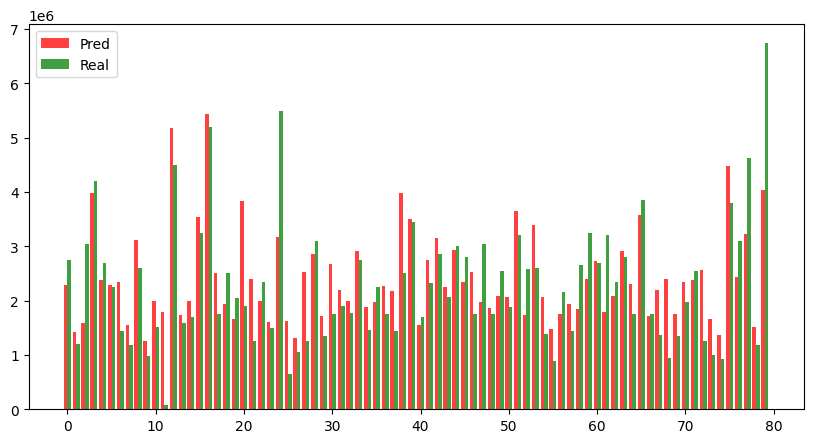

Least losses:                  0
166    266.225703
445    805.680859
176   1981.479546
136   2131.395595
153   3177.505021
353   6203.839716
397   9729.806514
288  10097.253927
111  11675.342219
508  15485.193891

Largest losses:                  0
105  5.843064e+06
497  5.737216e+06
387  4.414955e+06
264  4.035475e+06
356  3.556187e+06
257  3.297652e+06
266  3.012035e+06
509  3.000190e+06
154  2.877658e+06
297  2.852966e+06


In [63]:
# Test on some of the houses the model hasn't seen yet
test = df_shuffled[train_size:]
x_test = test.drop(columns=['Fiyat']).values
y_test = test['Fiyat'].values
y_mean = df['Fiyat'].mean()
y_std = df['Fiyat'].std()
y_dots = []
for i in range(len(x_test)):
    h = np.array(x_test[i]).reshape(-1,1)
    y_pred = nn.predict(h,y_mean,y_std)
    y_dots.append(y_pred[0,0])
n_samples = 80
indices = np.arange(n_samples)
plt.figure(figsize=(10,5))
plt.bar(indices-0.2,y_dots[:n_samples],width=0.4,color='red',alpha=0.75,label='Pred')
plt.bar(indices+0.2,y_test[:n_samples],width=0.4,color='green',alpha=0.75,label='Real')
plt.legend()
plt.show()
results = pd.DataFrame(abs(y_dots-y_test))

# Print loss in some of the best and worst guesses
print('Least losses: ',results.nsmallest(10,columns=0))
print('\nLargest losses: ',results.nlargest(10,columns=0))

In [60]:
# test cheap house
cheap_house = np.array([
    [100], #net metrekare
    [110], #brut metrekare
    [2],   #oda sayisi
    [5],   #bulundugu kat
    [0],   #esya durumu
    [5],   #binanin yasi
    [9],   #binanin kat sayisi
    [0],   #kullanim durumu
    [1],   #takas
    [0]    #banyo sayisi
])
# test expensive house
expensive_house = np.array([
    [500], #net metrekare
    [600], #brut metrekare
    [12],  #oda sayisi
    [2],   #bulundugu kat
    [1],   #esya durumu
    [0],   #binanin yasi
    [3],   #binanin kat sayisi
    [1],   #kullanim durumu
    [1],   #takas
    [5]    #banyo sayisi
])
for i in range(len(cheap_house)):
    cheap_house[i] = (cheap_house[i]-x_means[i])/x_stds[i]
    expensive_house[i] = (expensive_house[i]-x_means[i])/x_stds[i]
print('Expected price for a cheap house: ',nn.predict(cheap_house,y_mean,y_std)[0,0])
print('Expected price for an expensive house: ',nn.predict(expensive_house,y_mean,y_std)[0,0])

Expected price for a cheap house:  895324.8850249916
Expected price for an expensive house:  8931616.983874165
